<p>Explaination https://jgoslinski.medium.com/gauss-newton-optimization-can-be-used-for-dynamic-systems-too-python-example-ad1e2df4ec0c </p>

In [20]:
import numpy as np


class Vehicle:

    def __init__(self, x_in, dt, m, u, n):
        self.x = x_in
        self.m = m  # total mass
        self.u = u  # drag coefficient
        self.n = n  # size of input vector
        self.dt = dt  # sampling time
        self.v = np.zeros(n)  # velocity

    def simulate(self):
        self.v[0] = 0
        for i in range(0, self.n):
            if i == 0:
                self.v[i] = self.dt * self.x[i] / self.m
            else:
                self.v[i] = self.v[i-1] + (self.x[i]/self.m - (self.u/self.m)*self.v[i-1]*self.v[i-1])*self.dt
        print(self.v)
        return self.v

In [21]:
x = np.array([1000, 1200, 800, 500, 1800, 0, 1900, 600]) #force [N]
vehicle = Vehicle(x, 20, 1500, 0.1, 8) # dt:=20[s], mass:=1500[kg] #drag coef.= 0.1, vector size:=8
v = vehicle.simulate()

[13.33333333 29.0962963  38.63417035 43.31070486 64.80961532 59.20923367
 79.86825587 79.36300481]


In [22]:
import numpy as np

class GaussNetwonVehicle:

    def __init__(self, x_in, y_in, dt):

        state_size = 2  # how many parameters we search for

        self.beta = [10, 10]  # m and u, zeros here may lead to serious problems np.zeros(state_size)

        self.dt = dt  # sampling time in model
        self.r_s = y_in.shape[0]  # count how many residuals we have
        self.x = x_in  # opt input; time and force
        self.y = y_in   # target output; velocity
        self.J = np.zeros([self.r_s, state_size])  # Jacobian matrix
        self.r = np.zeros(self.r_s)  # residual vector
        #self.Jr = np.zeros(state_size)

    def set_jacobian(self):
        # define the Jacobian matrix row - only the first, the rest will be calculated based on the first
        for i in range(0, self.r_s):
            if i == 0:
                self.J[i, 0] = (self.x[i]/(self.beta[0]*self.beta[0]))*self.dt - \
                           (self.beta[1]/(self.beta[0]*self.beta[0]))*self.dt*0
                self.J[i, 1] = (1.0 / self.beta[0]) * self.dt * 0
            else:
                self.J[i, 0] = (self.x[i] / (self.beta[0] * self.beta[0])) * self.dt - \
                               (self.beta[1] / (self.beta[0] * self.beta[0])) * self.dt * self.y[i - 1] * self.y[i - 1]
                self.J[i, 1] = (1.0/self.beta[0])*self.dt*self.y[i-1]*self.y[i-1]
    def calc_res(self):
        err = 0
        for i in range(0, self.r_s):
            if i == 0:
                self.r[i] = self.y[i] - self.dt*self.x[i]/self.beta[0] + (self.beta[1]/self.beta[0])*self.dt*0
            else:
                self.r[i] = self.y[i] - self.y[i - 1] - self.dt * self.x[i] / self.beta[0] + \
                            (self.beta[1] / self.beta[0]) * self.dt*self.y[i - 1] * self.y[i - 1]
            err = err + self.r[i]*self.r[i]
        return err


    def opt_step(self):
        self.set_jacobian()
        err = self.calc_res()
        Jt = np.transpose(self.J)
        self.beta = self.beta - np.matmul(np.matmul(np.linalg.inv(np.matmul(Jt, self.J)), Jt), self.r)
        print(self.beta)
        return err

    def opt(self, e):

        err = 100
        errp = 10
        while np.abs(err-errp) > e:
            errp = err
            err = self.opt_step()


[13.33333333 29.0962963  38.63417035 43.31070486 64.80961532 59.20923367
 79.86825587 79.36300481]
[19.93508718  9.93568804]
[39.6122058   9.80831381]
[78.20584708  9.55848885]
[152.44152565   9.0779453 ]
[289.79833786   8.18880505]
[525.08089049   6.66577037]
[871.19067675   4.42532711]
[1249.71043252    1.97508714]
[1.48562788e+03 4.47942653e-01]
[1.53857122e+03 1.05228975e-01]
[1.54052520e+03 9.25804366e-02]
[1.54052769e+03 9.25643526e-02]
[1.54052769e+03 9.25643525e-02]
[12.98256445 28.35909505 37.77867524 42.55482486 63.74722551 58.86377456
 79.3667453  79.5865364 ]


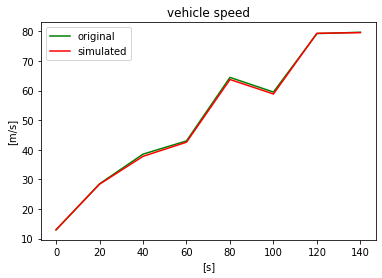

In [23]:
xv = np.array([1000, 1200, 800, 500, 1800, 0, 1900, 600]) #forces
vehicle = Vehicle(xv, 20, 1500, 0.1, 8)
mu, sigma = 0, 0.5 # mean and standard deviation
s = np.random.normal(mu, sigma, 8)
yv = vehicle.simulate() + s
gnv = GaussNetwonVehicle(xv, yv, 20)
gnv.opt(0.0001)
vehicle = Vehicle(xv, 20, gnv.beta[0], gnv.beta[1], 8)
yvs = vehicle.simulate()
t = list(range(0, 160, 20))
plt.plot(t, yv, 'g', label='original')
plt.plot(t, yvs, 'r', label='simulated')
plt.ylabel('[m/s]')
plt.xlabel('[s]')
plt.title('vehicle speed')
plt.legend()
plt.show()